# 1.竞赛和数据概述
在这个操场比赛中，我们面临着预测俄罗斯软件公司-1C公司下个月每个产品和商店的总销售额的挑战。
1C公司是做什么的？：
1C：Enterprise 8程序系统旨在实现日常企业活动的自动化：经济和管理活动的各种业务任务，如管理会计、商业会计、人力资源管理、客户关系管理、SRM、MRP、MRP等。
数据：我们获得了每个商店-商品组合的每日销售数据，但我们的任务是预测每月的销售额。

# 2.Imports

In [2]:
# 始终从检查文件开始！
!ls ./competitive-data-science-predict-future-sales

item_categories.csv  sales_train.csv	    shops.csv
items.csv	     sample_submission.csv  test.csv


In [3]:
# Basic packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd # generating random numbers
import datetime # manipulating date formats
# Viz
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots


# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


# settings
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Import all of them 
sales=pd.read_csv("./competitive-data-science-predict-future-sales/sales_train.csv")

# settings
import warnings
warnings.filterwarnings("ignore")

item_cat=pd.read_csv("./competitive-data-science-predict-future-sales/item_categories.csv")
item=pd.read_csv("./competitive-data-science-predict-future-sales/items.csv")
sub=pd.read_csv("./competitive-data-science-predict-future-sales/sample_submission.csv")
shops=pd.read_csv("./competitive-data-science-predict-future-sales/shops.csv")
test=pd.read_csv("./competitive-data-science-predict-future-sales/test.csv")

In [5]:
#formatting the date column correctly
sales.date=sales.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))
# check
print(sales.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None


In [6]:
# Aggregate to monthly level the required metrics

monthly_sales = sales.groupby(["date_block_num", "shop_id", "item_id"])[
    ["date", "item_price", "item_cnt_day"]
].agg({"date": ["min", "max"], "item_price": "mean", "item_cnt_day": "sum"})

## Lets break down the line of code here:
# aggregate by date-block(month),shop_id and item_id
# select the columns date,item_price and item_cnt(sales)
# Provide a dictionary which says what aggregation to perform on which column
# min and max on the date
# average of the item_price
# sum of the sales

In [7]:
# take a peak
monthly_sales.head(20)

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-03 2013-01-31      221.0          6.0
                       33      2013-01-03 2013-01-28      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0
                       61      2013-01-10 2013-01-10      195.0          1.0
                       75      2013-01-17 2013-01-17       76.0          1.0
                       88      2013-01-16 2013-01-16       76.0          1.0
                       95      2013-01-06 2013-01-06      193.0          1.0
                       96      2013-01-10 2013-01-10       70.0          1.0
                       98      2013-01-04 2013-01-31      268.0         25.0
                       111     2013-01-17 2013-01-17       89.0          1.0
                       149     2013-01-11 2013-01-28       99.0          3.0
                       151     2013-01-16 2013-01-16       75.0          1.0
                       153     2013-01-09 2013-01-09      258.0          1.0
                       198     2013-01-10 2013-01-10      112.0          1.0
                       210     2013-01-05 2013-01-25      118.0          2.0
                       282     2013-01-04 2013-01-04      109.0          1.0
                       306     2013-01-22 2013-01-22       59.0          1.0
                       351     2013-01-21 2013-01-21       89.0          1.0

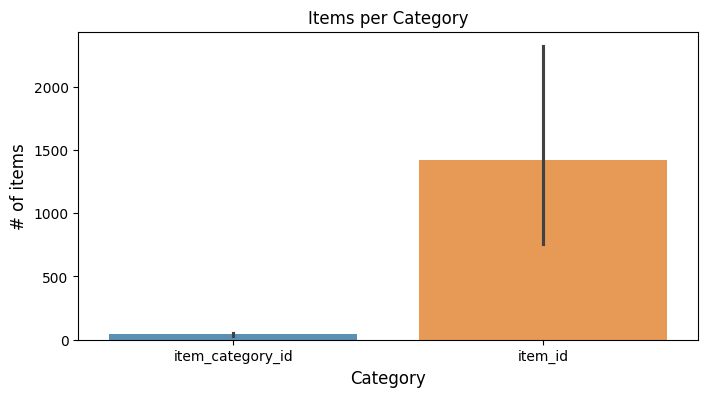

In [8]:
# number of items per cat 
x=item.groupby(['item_category_id']).count()
x=x.sort_values(by='item_id',ascending=False)
x=x.iloc[0:10].reset_index()
x
# #plot
plt.figure(figsize=(8,4))
ax = sns.barplot([x.item_category_id, x.item_id], alpha=0.8)
plt.title("Items per Category")
plt.ylabel('# of items', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

# 3.Single series
该目标要求我们预测下个月商店商品组合的销售额。
随着时间的推移，每个商店商品的销售本身就是一个时间序列。在我们深入研究所有组合之前，首先让我们了解如何预测单个系列。
我选择预测整个公司每月的总销售额。
首先让我们计算每月的总销售额并绘制该数据。

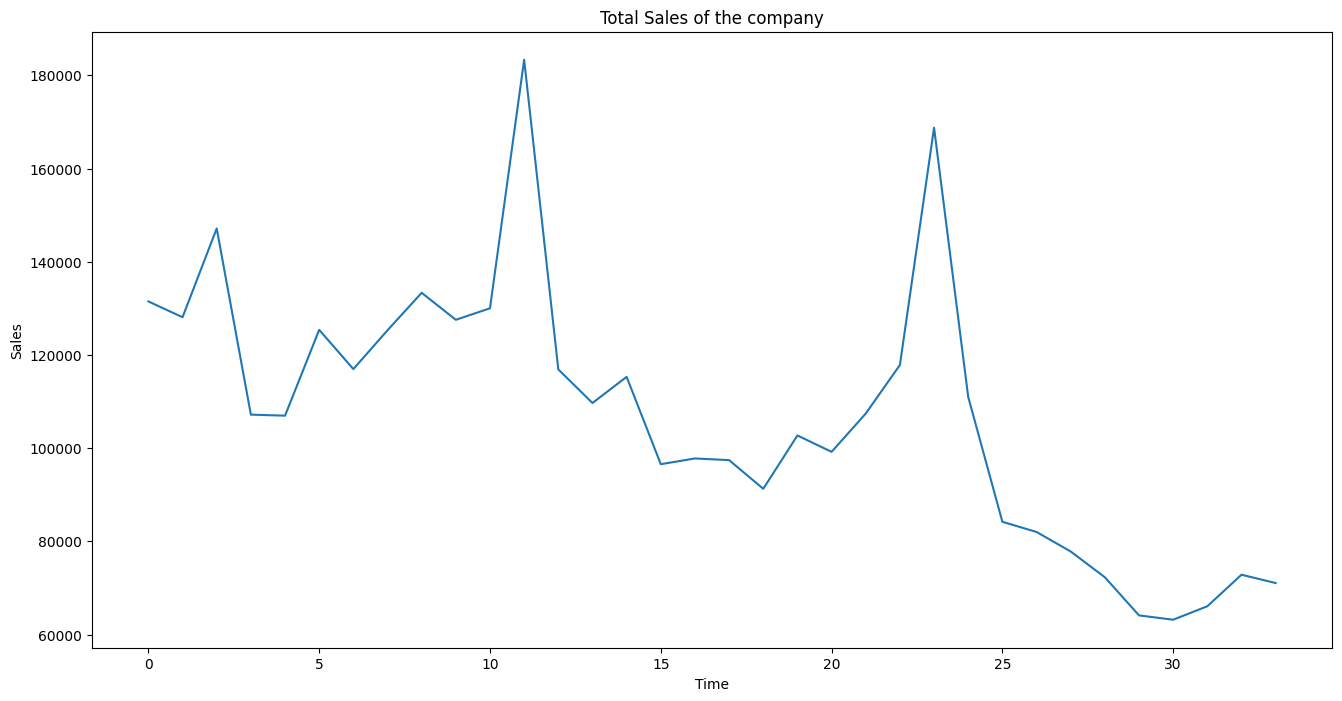

In [9]:
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)

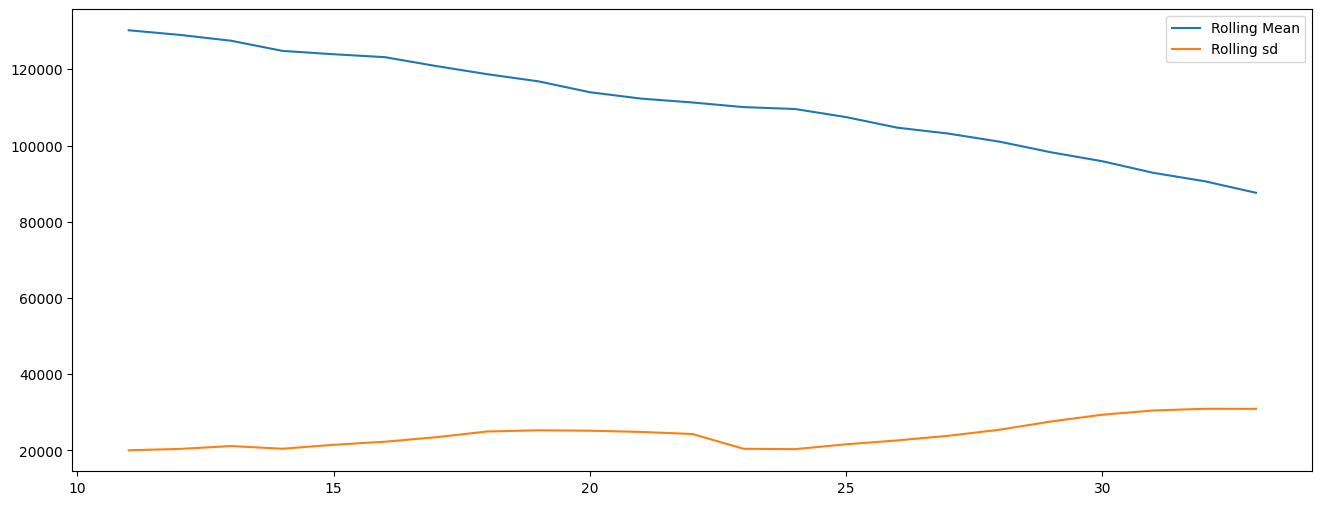

In [10]:
plt.figure(figsize=(16,6))
# 滚动均值
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean')
# 滚动标准差
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd')
plt.legend()

快速观察：有明显的“季节性”（例如：一年中某个时候的销售高峰）和下降的“趋势”。

让我们快速分解为趋势、季节性和残差来检查一下。

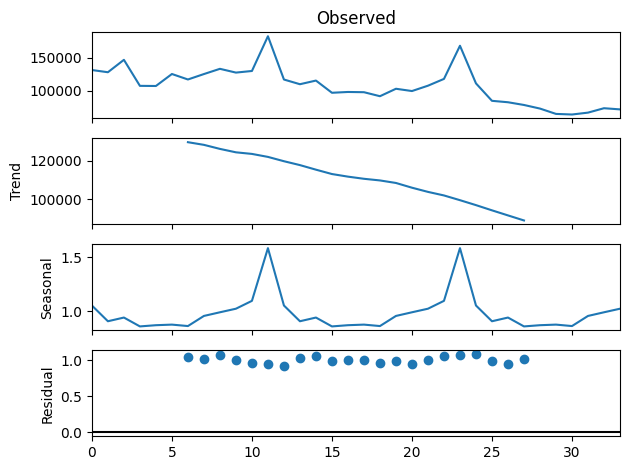

In [11]:
import statsmodels.api as sm
# multiplicative
res = sm.tsa.seasonal_decompose(ts.values, period=12, model="multiplicative")
fig = res.plot()

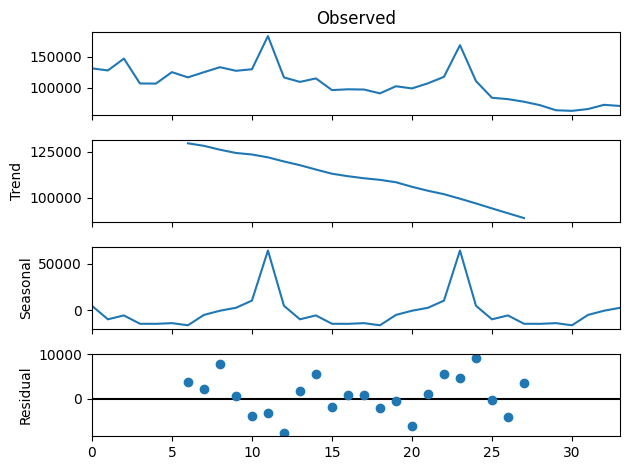

In [12]:
# Additive model
res = sm.tsa.seasonal_decompose(ts.values,period=12,model="additive")
fig = res.plot()

我们假设一个加法模型，然后我们可以编写
yt=St+Tt+Et
其中yt是周期t的数据，St是周期t的季节性分量，Tt是周期tt的趋势周期分量，Et是周期t的剩余（或不规则或误差）分量。
同样对于乘法模型来说也是一样的
yt=St x Tt x Et

平稳性是指序列的时不变性。（即）时间序列中的两个点仅通过它们之间的距离而不是方向（前进/后退）来相互关联
当时间序列是平稳的时，建模可能更容易。统计建模方法假设或要求时间序列是平稳的。
有多种测试可用于检查平稳性：
ADF( Augmented Dicky Fuller Test)
KPSS
PP (Phillips-Perron test)

In [13]:
# Stationarity tests
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                 -2.395704
p-value                         0.142953
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


In [15]:
# to remove trend
from pandas import Series as Series
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob

[]

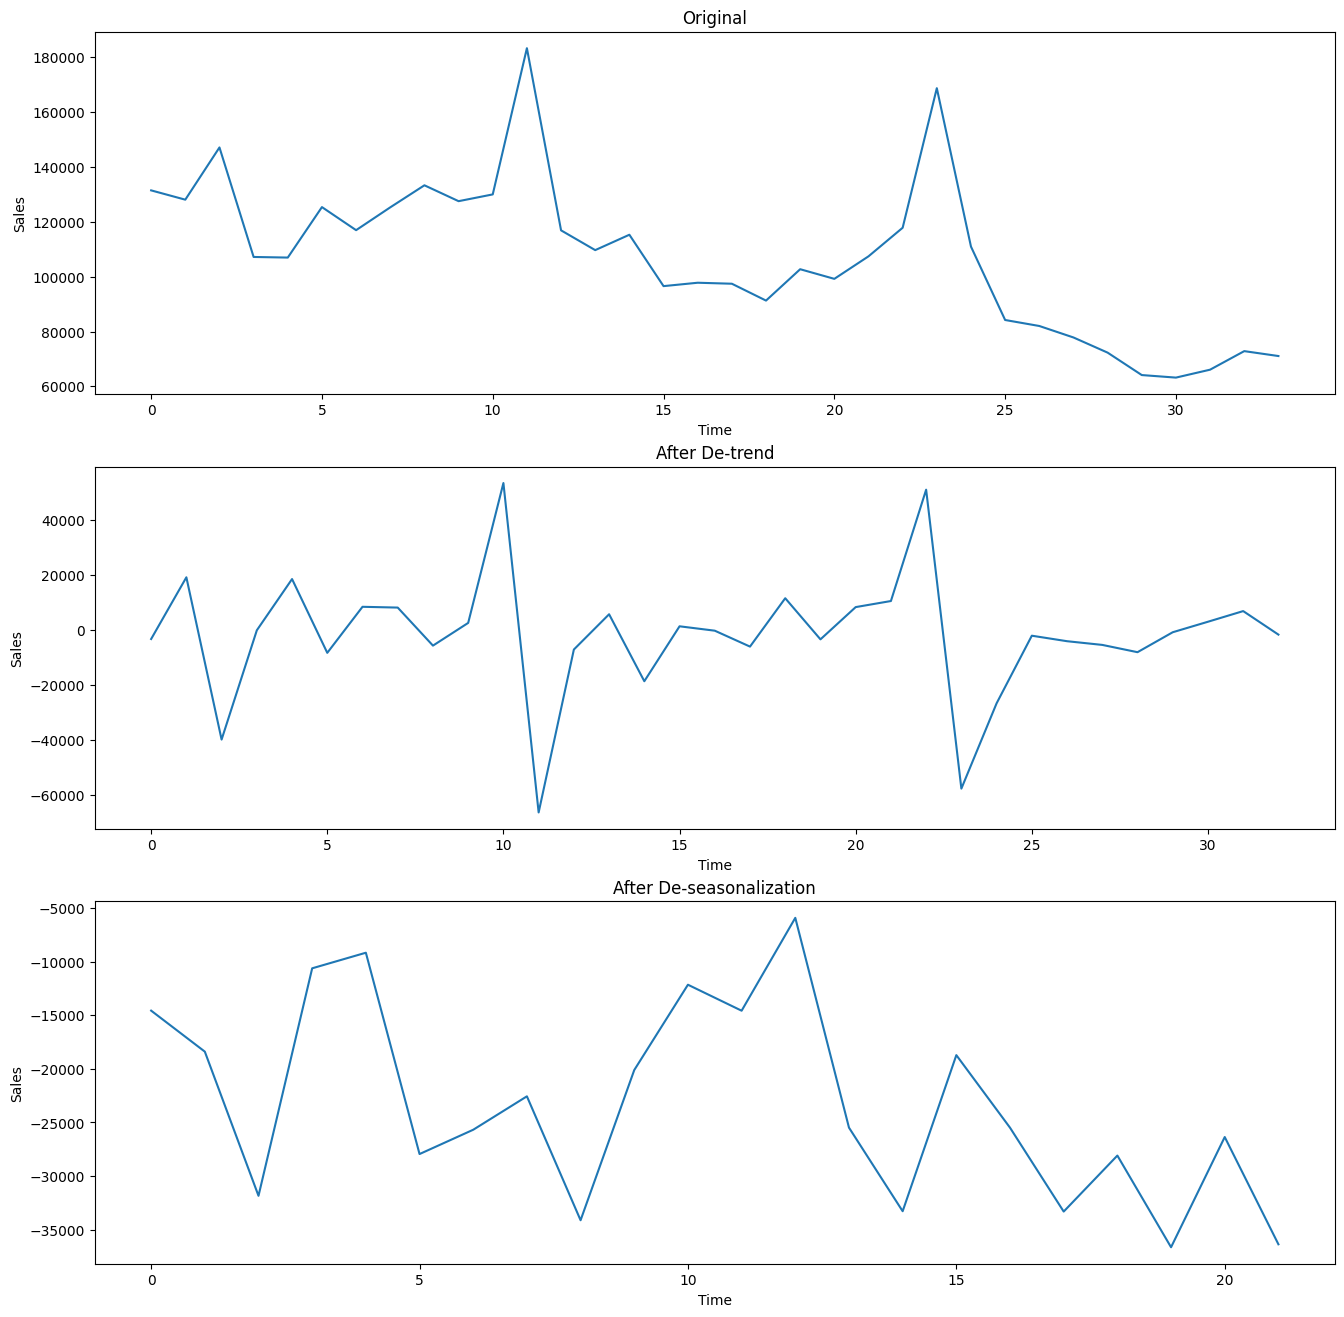

In [16]:
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,16))
plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)
plt.subplot(312)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts)
plt.plot(new_ts)
plt.plot()

plt.subplot(313)
plt.title('After De-seasonalization')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts,12)       # assuming the seasonality is 12 months long
plt.plot(new_ts)
plt.plot()

In [17]:
# now testing the stationarity again after de-seasonality
test_stationarity(new_ts)

Results of Dickey-Fuller Test:
Test Statistic                 -3.270101
p-value                         0.016269
#Lags Used                      0.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64


现在经过变换，我们的DF检验的p值在5%以内。因此我们可以假设序列的平稳性
我们可以使用上面定义的逆变换函数轻松取回原始级数。
现在让我们开始做预测吧！

# 4.AR, MA and ARMA models
TL：模型的DR版本
MA：系列中的下一个值是前n个值的平均值的函数
AR：下一个值的误差（平均值差）是前n个值中误差的函数
ARMA：两者的混合物
现在，我们如何确定我们的时间序列是在AR过程还是MA过程中？
我们来测试吧。

In [18]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh',title=''):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

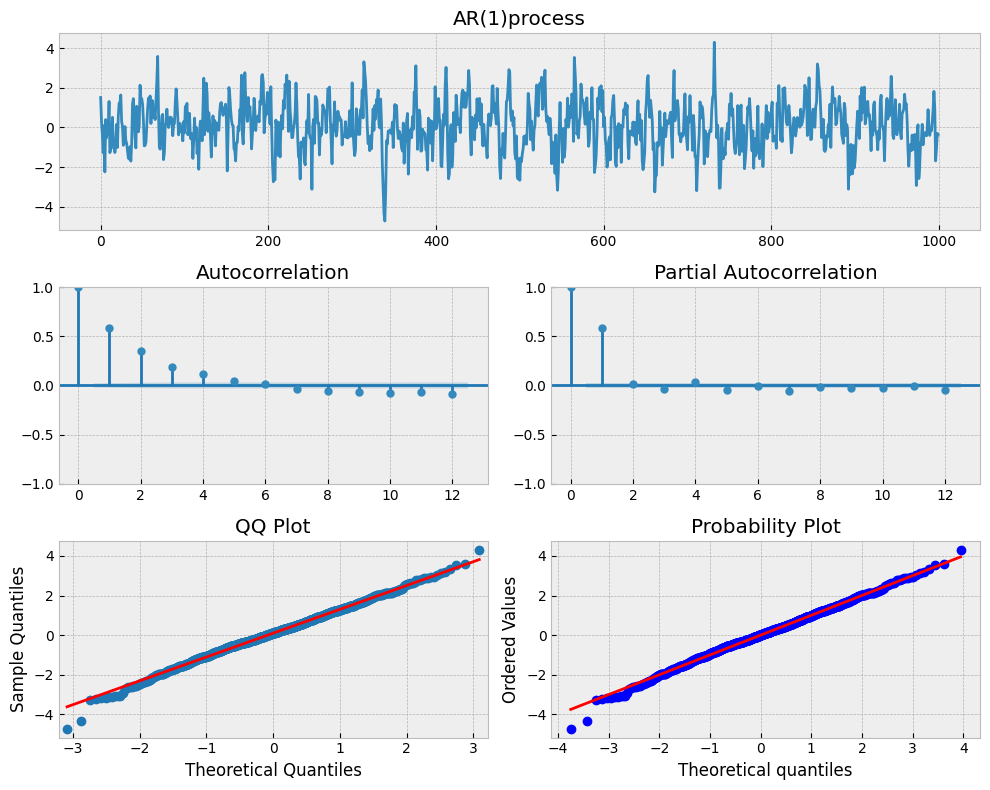

In [19]:
# Simulate an AR(1) process with alpha = 0.6
np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
limit=12    
_ = tsplot(x, lags=limit,title="AR(1)process")